## Урок 7

Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
    - для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

from sklearn.base import BaseEstimator, TransformerMixin

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score

https://archive.ics.uci.edu/ml/datasets/Early+stage+diabetes+risk+prediction+dataset.
Data Set Information:

This has been col-
lected using direct questionnaires from the patients of Sylhet Diabetes
Hospital in Sylhet, Bangladesh and approved by a doctor.

In [2]:
data_df = pd.read_csv('diabetes_data_upload.csv')
data_df

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,39,Female,Yes,Yes,Yes,No,Yes,No,No,Yes,No,Yes,Yes,No,No,No,Positive
516,48,Female,Yes,Yes,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,No,No,No,Positive
517,58,Female,Yes,Yes,Yes,Yes,Yes,No,Yes,No,No,No,Yes,Yes,No,Yes,Positive
518,32,Female,No,No,No,Yes,No,No,Yes,Yes,No,Yes,No,No,Yes,No,Negative


In [3]:
list_replace = {'Positive': '1', 'Negative': '0'}
data_df['class'] = data_df['class'].map(list_replace)
data_df['class'] = data_df['class'].astype('int')

In [4]:
data_df = data_df.rename(columns={'class': 'target'})

In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  target              520 no

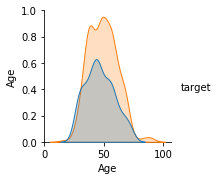

In [6]:
sns.pairplot(data_df, hue='target',  plot_kws = {'alpha': 0.4})

In [7]:
for column in data_df.columns[1:-1].tolist():
    print(data_df.groupby(column).agg({'target': 'count'})['target'])
    print('----')

Gender
Female    192
Male      328
Name: target, dtype: int64
----
Polyuria
No     262
Yes    258
Name: target, dtype: int64
----
Polydipsia
No     287
Yes    233
Name: target, dtype: int64
----
sudden weight loss
No     303
Yes    217
Name: target, dtype: int64
----
weakness
No     215
Yes    305
Name: target, dtype: int64
----
Polyphagia
No     283
Yes    237
Name: target, dtype: int64
----
Genital thrush
No     404
Yes    116
Name: target, dtype: int64
----
visual blurring
No     287
Yes    233
Name: target, dtype: int64
----
Itching
No     267
Yes    253
Name: target, dtype: int64
----
Irritability
No     394
Yes    126
Name: target, dtype: int64
----
delayed healing
No     281
Yes    239
Name: target, dtype: int64
----
partial paresis
No     296
Yes    224
Name: target, dtype: int64
----
muscle stiffness
No     325
Yes    195
Name: target, dtype: int64
----
Alopecia
No     341
Yes    179
Name: target, dtype: int64
----
Obesity
No     432
Yes     88
Name: target, dtype: int64
----


In [8]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
for column in data_df.columns[1:-1].tolist():
    data_df[column] = labelencoder.fit_transform(data_df[column])

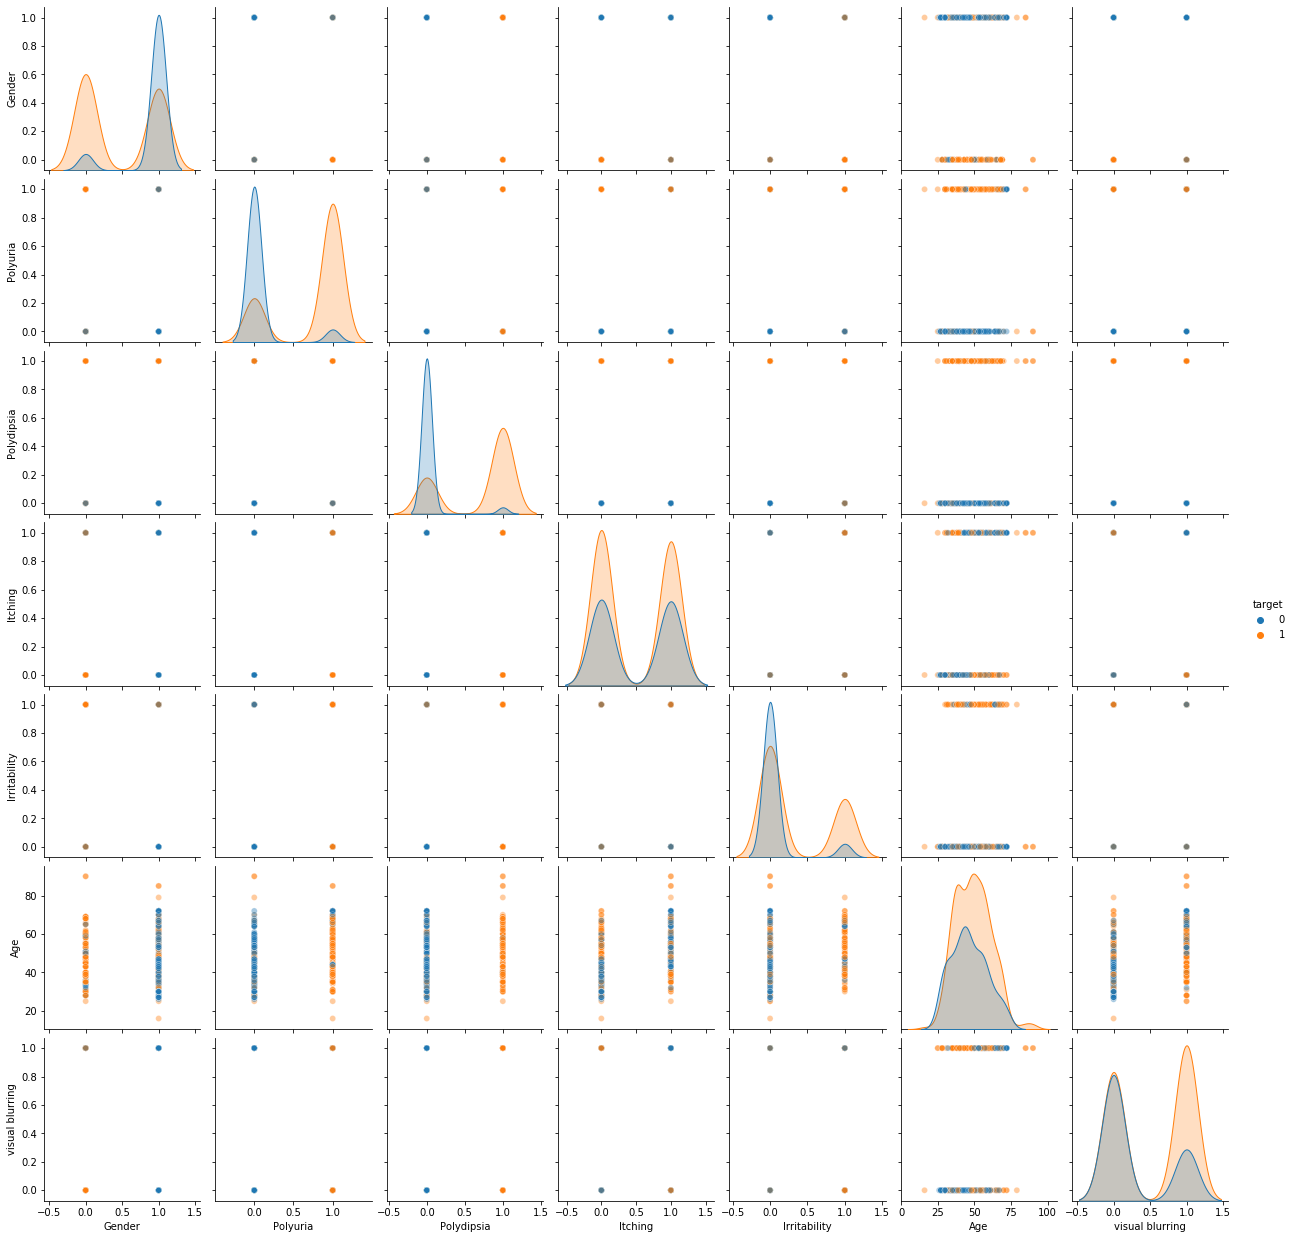

In [9]:
sns.pairplot(data_df[['target', 'Gender', 'Polyuria', 'Polydipsia', 'Itching', 'Irritability', 'Age', 'visual blurring']], hue='target',  plot_kws = {'alpha': 0.4})

In [10]:
data_df.iloc[:, 1:-1].head()

,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity
0,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1
1,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0
2,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0
3,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0
4,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    data_df.drop(columns='target'), data_df['target'], test_size=0.3, random_state=99)

In [12]:
model_xgb = XGBClassifier(random_state=99)
model_xgb.fit(X_train, y_train)
y_proba = model_xgb.predict_proba(X_test)[:, 1]
y_pred = model_xgb.predict(X_test)

[21:47:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [13]:
roc_auc_score(y_test, y_proba)

0.9800803774244277

In [14]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [15]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test)

display(shap.force_plot(explainer.expected_value, shap_values[0, :], X_test.iloc[0, :]),
        shap.force_plot(explainer.expected_value, shap_values[1, :], X_test.iloc[1, :]))

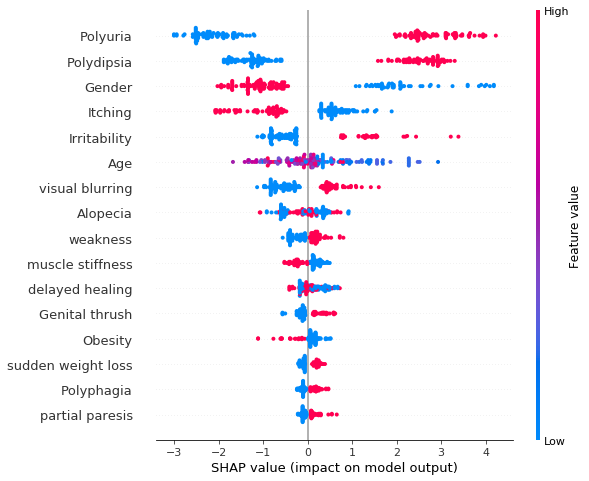

In [16]:
shap.summary_plot(shap_values, X_test)

Ряд признаков(Polyuria, Polydipsia, Gender...) обладают хорошей разделяющей способностью, поскольку их значения разведены относительно вертикальной линии и четко прослеживается вклад каждой группы в классификацию. Данные признаки значительно увеличивают качество модели(roc_auc 0.98).

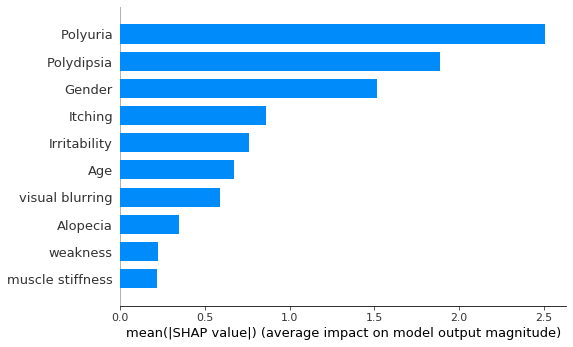

In [17]:
# top10  признаков
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10)